## **Stage 1:** Data Preparation

In [1]:
!pip install -q gdown

In [2]:
!gdown 129DMIRtu7ho-k5O1xtO_xwjy-tEC-Pzt

Downloading...
From (uriginal): https://drive.google.com/uc?id=129DMIRtu7ho-k5O1xtO_xwjy-tEC-Pzt
From (redirected): https://drive.google.com/uc?id=129DMIRtu7ho-k5O1xtO_xwjy-tEC-Pzt&confirm=t&uuid=c4ca96b2-86c0-468c-941a-62bdadfb6458
To: /kaggle/working/PlantVillage_Noisy_Dataset.zip
100%|█████████████████████████████████████████| 266M/266M [00:01<00:00, 244MB/s]


In [3]:
!rm -rf /kaggle/working/PlantVillage/

In [4]:
!unzip -q /kaggle/working/PlantVillage_Noisy_Dataset.zip

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
import numpy as np
from glob import glob
from skimage.io import imread
from skimage.transform import resize

data = glob("./PlantVillage/Noisy_Dataset/Train_Data/P*/*")

# Use list comprehension to read and resize images
images = [resize(imread(file), (16, 16, 3), anti_aliasing=True) for file in data]

# Converting the images into float32 array
images_arr = np.asarray(images, dtype="float32")
print("Dataset:", images_arr.shape)

Dataset: (3007, 16, 16, 3)


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

transf = Compose([Resize((128, 128)), ToTensor()])
noise_train = ImageFolder("./PlantVillage/Noisy_Dataset/Train_Data/", transform=transf)
pure_train = ImageFolder("./PlantVillage/Pure_Dataset/Train_Data/", transform=transf)
noise_test = ImageFolder("./PlantVillage/Noisy_Dataset/Test_Data/", transform=transf)
pure_test = ImageFolder("./PlantVillage/Pure_Dataset/Test_Data/", transform=transf)

In [8]:
pure_data = glob("./PlantVillage/Pure_Dataset/Train_Data/P*/*")

# Use list comprehension to read and resize images
pure_images = [
    resize(imread(file), (128, 128, 3), anti_aliasing=True) for file in pure_data
]

# Converting the images into float32 array
images_pure = np.asarray(pure_images, dtype="float32")
print("Dataset:", images_pure.shape)

Dataset: (3007, 128, 128, 3)


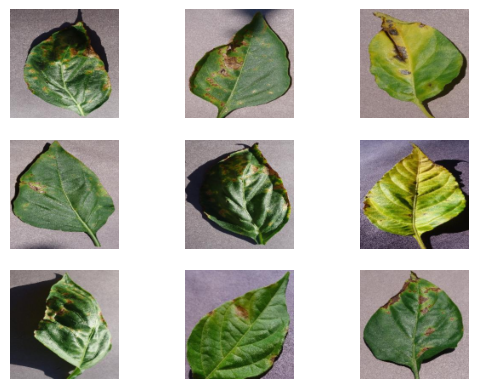

In [9]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.imshow(images_pure[i], cmap="gray")

In [10]:
test_data = glob("./PlantVillage/Noisy_Dataset/Test_Data/P*/*")

# Use list comprehension to read and resize images
images = [resize(imread(file), (128, 128, 3), anti_aliasing=True) for file in test_data]

# Converting the images into float32 array
images_test = np.asarray(images, dtype="float32")
print("Dataset:", images_test.shape)

Dataset: (1613, 128, 128, 3)


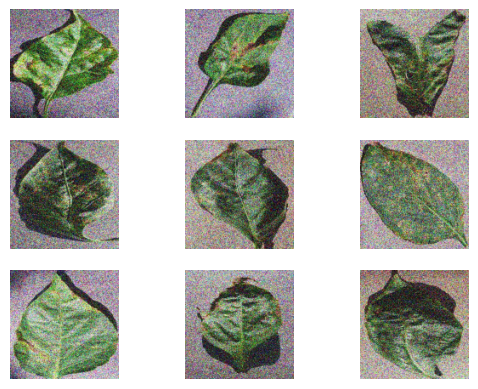

In [11]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.imshow(images_test[i], cmap="gray")

In [12]:
test_data = glob("./PlantVillage/Pure_Dataset/Test_Data/P*/*")

# Use list comprehension to read and resize images
images = [resize(imread(file), (128, 128, 3), anti_aliasing=True) for file in test_data]

# Converting the images into float32 array
images_ground = np.asarray(images)
images_ground = images_ground.astype("float32")
print("Dataset:", images_ground.shape)

Dataset: (1613, 128, 128, 3)


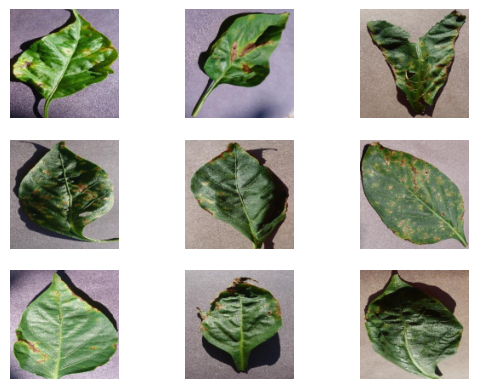

In [13]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.imshow(images_ground[i], cmap="gray")

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(noise_train, batch_size=16)
pure_loader = DataLoader(pure_train, batch_size=16)
test_loader = DataLoader(noise_test, batch_size=16)
ground_loader = DataLoader(pure_test, batch_size=16)

In [15]:
image, label = next(iter(train_loader))
print(image.shape, label.shape)

torch.Size([16, 3, 128, 128]) torch.Size([16])


In [16]:
from torch import nn


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(49152, 5000),
            nn.ReLU(),
            nn.Linear(5000, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 5),
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 50),
            nn.ReLU(),
            nn.Linear(50, 500),
            nn.ReLU(),
            nn.Linear(500, 5000),
            nn.ReLU(),
            nn.Linear(5000, 49152),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.encoder(x)
        z = self.decoder(y)
        z = z.view(z.size(0), 3, 128, 128)
        return z

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using PyTorch version:", torch.__version__, "CUDA:", torch.cuda.is_available())

Using PyTorch version: 2.0.0 CUDA: True


In [18]:
model = AutoEncoder().to(device)

# Initialization of Mean Square Error
loss_func = nn.MSELoss()

# Initialization of Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [19]:
import os
from torchvision.utils import save_image


def make_dir():
    image_dir = "./PlantVillage/Denoised_Images"
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)


def save_pic(img, name):
    img = img.view(3, 128, 128)
    save_image(img, name)

In [20]:
from tqdm import tqdm

make_dir()
EPOCH = 5
for epoch in range(EPOCH):
    # Initialize tqdm for the outer loop (epochs)
    with tqdm(
        total=len(train_loader), desc=f"Epoch {epoch + 1}", unit="batch"
    ) as epoch_progress_bar:
        for x, y in zip(train_loader, pure_loader):
            t_x, _ = x
            t_x = t_x.to(device)
            t_y, label = y
            t_y = t_y.to(device)

            optimizer.zero_grad()
            decoded1 = model(t_x)
            loss = loss_func(decoded1, t_y)
            train_loss = loss.item()
            loss.backward()
            optimizer.step()

            # Update progress bar for the inner loop (batches)
            epoch_progress_bar.set_postfix(train_loss=train_loss)
            epoch_progress_bar.update(1)
        epoch_progress_bar.close()

Epoch 5: 100%|██████████| 188/188 [00:18<00:00, 10.18batch/s, train_loss=0.0189]


In [21]:
model.eval()
total_loss = 0.0

# Iterate over batches in the train_loader and pure_loader
for batch_idx, (x, y) in enumerate(zip(train_loader, pure_loader)):
    # Convert the images and labels to GPU for faster execution
    t_x, _ = x
    eval_x = t_x.to(device)
    t_y, _ = y
    eval_y = t_y.to(device)

    # Passing the data to the model (Forward Pass)
    decoded2 = model(eval_x)

    # Calculating mean square error loss
    loss = loss_func(decoded2, eval_y)
    print(loss)

    # Accumulate total loss
    total_loss += loss.item()

    # Save images (assuming save_pic is a function that saves the images)
    for i in range(len(decoded2)):
        save_pic(
            decoded2[i].cpu().data, name=f"./PlantVillage/Denoised_Images/ae_{i}.jpg"
        )

tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0324, device='cuda:0', grad_fn=

## **Stage 3:** Visualize the Denoised images

### Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

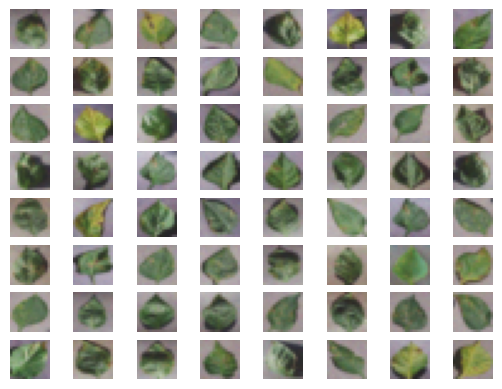

In [22]:
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.axis("off")
    plt.imshow(images_arr[i], cmap="gray")

In [23]:
data = glob("./PlantVillage/Denoised_Images/*.jpg")
img = imread(data[0])
print(img.shape)

(128, 128, 3)


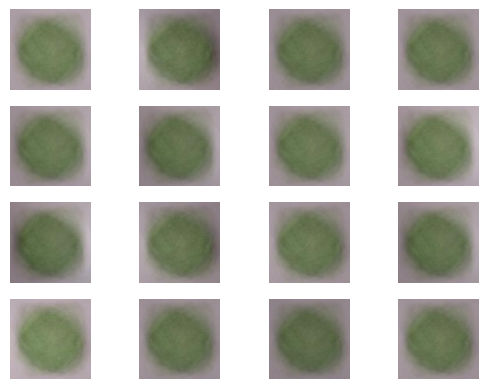

In [24]:
images_denoised = [imread(img) for img in data]
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(images_denoised[i], cmap="gray")

## **Stage 4:** Test the Model

In [25]:
model.eval()
for x, y in zip(test_loader, ground_loader):
    # Convert the images and labels to gpu for faster execution
    t_x, _ = x
    eval_x = t_x.to(device)
    t_y, _ = y
    eval_y = t_y.to(device)
    # Passing the data to the model (Forward Pass)
    decoded2 = model(eval_x)
    # Calculating mean square error loss
    loss = loss_func(decoded2, eval_y)
    print(loss)

tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0327, device='cuda:0', grad_fn=

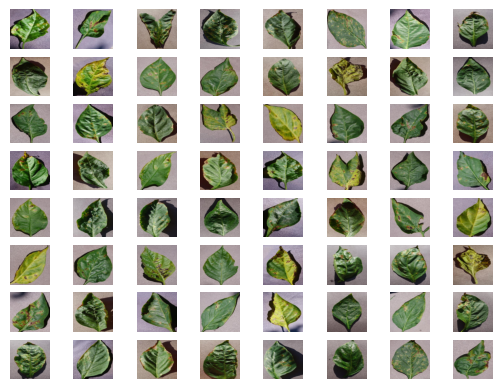

In [26]:
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.axis("off")
    plt.imshow(images_ground[i], cmap="gray")